In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
from matplotlib import pyplot as plt
from PIL import Image
import os
import RGBHSL
import time

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
locloc = "BigDataCubes" 
namename = "\CombinedDatasets\Part0"
all_photos = np.load(locloc + namename + 'Photos.npy')[1700:]
#all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
#all_vectors = np.load(locloc + namename + 'Vectors.npy')
#all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
all_albedos = np.load(locloc + namename + 'Albedos.npy')[1700:]
#all_normals = np.load(locloc + namename + 'Normals.npy')
all_masks = np.load(locloc + namename + 'Masks.npy')[1700:,:,:, 0]
#all_depth = np.load(locloc + namename + 'Depth.npy')[0:1700,:,:]
# Цель просто сделать рабочий генератор маски.
all_differences = np.zeros(all_photos.shape)

In [3]:
# Делатель картинок, не обязателен
my_picture = np.concatenate([all_photos[0], all_albedos[0], all_normals[0], all_masks[0], all_depth[0]], axis = 1)
bigpicture = np.round(my_picture * 255, 0).astype("int16")
bigpicture = np.clip(bigpicture, 0, 255)
bigpicture = bigpicture.astype(np.uint8)
plt.imshow(bigpicture)
my_big_picture = Image.fromarray(bigpicture)
#my_big_picture.save('my_big_picture.png')

NameError: name 'all_normals' is not defined

In [18]:
def normalizeNegativeImage(imim, mask):
    mask = np.stack([mask, mask, mask], axis=2)
    nonneg = imim - np.ones(imim.shape) * imim.min()
    nmax = 0.01
    if nonneg.max() != 0:
        nmax = nonneg.max()
    nonneg = nonneg * (1.0/nmax)
    return nonneg * mask

In [16]:
all_photos = np.load(locloc + "\CombinedDatasets" + "\SmallHSL" + "Photo.npy")
all_albedos = np.load(locloc + "\CombinedDatasets" + "\SmallHSL" + "Albedo.npy")

In [6]:
all_differences = (all_photos - all_albedos)[:, :, :, 1:3]

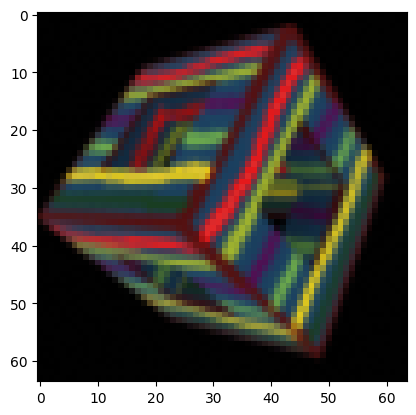

In [7]:
plt.imshow(RGBHSL.image_coverter( all_photos[2] - np.stack([np.zeros((64,64)), all_differences[2, :,:,0],all_differences[2, :,:,1]], axis=2)
                                 , RGBHSL.pixel_hsl_to_rgb, normalized_input=True, normalize_output=True))

In [5]:

prevtime = time.time()
for photo in range(len(all_photos)):
    all_photos[photo] = RGBHSL.image_coverter(all_photos[photo],RGBHSL.pixel_rgb_to_hsl, normalized_input= True,  normalize_output=True)
    all_albedos[photo] = RGBHSL.image_coverter(all_albedos[photo],RGBHSL.pixel_rgb_to_hsl, normalized_input= True,  normalize_output=True)
    if photo % 100 == 0: 
        nowtime = time.time()
        seconds, milliseconds = divmod((nowtime - prevtime) * 1000, 1000)
        prevtime = nowtime
        print(f"{photo // 100}00 сек {seconds} мсек {milliseconds}")
print("finished")


000 сек 0.0 мсек 147.9949951171875
100 сек 13.0 мсек 960.613489151001
200 сек 13.0 мсек 805.3543567657471
300 сек 13.0 мсек 894.6051597595215
400 сек 13.0 мсек 940.732479095459
500 сек 14.0 мсек 12.84027099609375
600 сек 13.0 мсек 835.7651233673096
700 сек 13.0 мсек 798.0356216430664
800 сек 13.0 мсек 974.299430847168
900 сек 14.0 мсек 10.433197021484375
1000 сек 14.0 мсек 86.86351776123047
1100 сек 13.0 мсек 978.4212112426758
1200 сек 13.0 мсек 867.6290512084961
1300 сек 13.0 мсек 966.853141784668
1400 сек 13.0 мсек 992.0194149017334
1500 сек 13.0 мсек 859.0619564056396
1600 сек 13.0 мсек 835.0756168365479
1700 сек 13.0 мсек 823.9889144897461
finished


In [13]:
all_photos = np.concatenate([all_photos, all_photos1], axis=0)
all_albedos = np.concatenate([all_albedos, all_albedos1], axis=0)

In [14]:
del all_photos_test

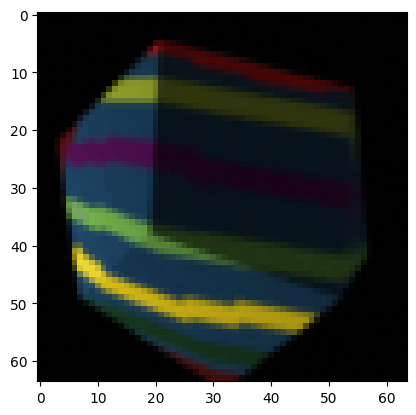

In [6]:
plt.imshow(RGBHSL.image_coverter(all_photos[0], RGBHSL.pixel_hsl_to_rgb, normalized_input= True,  normalize_output=True))

In [15]:

np.save(locloc + "\CombinedDatasets" + "\SmallHSL" + "Photo", all_photos)
np.save(locloc + "\CombinedDatasets" + "\SmallHSL" + "Albedo", all_albedos)


In [10]:
myHSL_Photo = RGBHSL.image_coverter(all_photos[0], RGBHSL.pixel_rgb_to_hsl, normalized_input= True,  normalize_output=True)
myHSL_Albedo = RGBHSL.image_coverter(all_albedos[0], RGBHSL.pixel_rgb_to_hsl, normalized_input= True,  normalize_output=True)
myHSL_Diff = (myHSL_Photo - myHSL_Albedo)
myHSL_Diff[:,:,0] = np.zeros((64,64))

In [11]:
myRGB_Photo = RGBHSL.image_coverter(myHSL_Photo, RGBHSL.pixel_hsl_to_rgb, normalized_input= True,  normalize_output=True)
myRGB_Albedo = RGBHSL.image_coverter(myHSL_Albedo, RGBHSL.pixel_hsl_to_rgb, normalized_input= True,  normalize_output=True)
myRGB_Diff = RGBHSL.image_coverter(np.clip(myHSL_Photo - myHSL_Diff, 0, 1), RGBHSL.pixel_hsl_to_rgb, normalized_input= True,  normalize_output=True)

In [12]:
myHSL_Diff_norm = normalizeNegativeImage(myHSL_Diff, np.zeros((64,64)) + 1)
myHSL_Diff_norm = np.clip(myHSL_Diff_norm, 0, 1)
#myRGB_Diff_norm = RGBHSL.image_coverter(myHSL_Diff_norm, RGBHSL.pixel_hsl_to_rgb, normalized_input= True,  normalize_output=True)

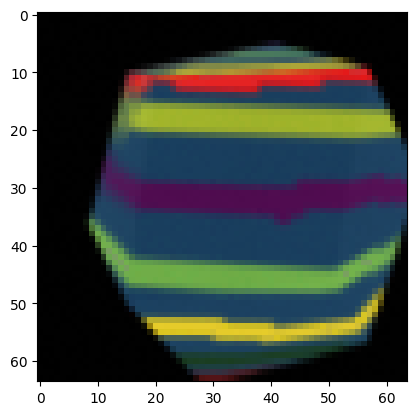

In [13]:
ans = all_photos[5] - np.stack([np.zeros((64,64)), all_differences[5,:,:,0], all_differences[5,:,:,1]], axis = 2)
ans = RGBHSL.image_coverter(ans, RGBHSL.pixel_hsl_to_rgb, normalized_input= True,  normalize_output=True)
plt.imshow(ans)

In [14]:
batch_size = 64
train_size = 1
lightjumps = 57
# Test Dataset нужно грузить отдельно

dataset = tf.data.Dataset.from_tensor_slices((all_photos, all_differences))

dataset = dataset.shuffle(buffer_size=512, seed=13)

train_dataset = dataset.batch(64, drop_remainder=True)
print(all_photos.shape), print(all_differences.shape)

(1700, 64, 64, 3)
(1700, 64, 64, 2)


(None, None)

In [18]:
#4,592,758 | 4,592,721
def GiveModel(dropout = 0.4):
    image_input = keras.layers.Input(shape=(64, 64, 3), name='image_input')
    x = keras.layers.Conv2D(4, (3, 3), activation='relu', padding="same")(image_input)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(7, (3, 3), activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    # Полносвязный слой
    z = keras.layers.Dense(2*16*16, activation='tanh')(x)
    do = keras.layers.Dropout(dropout)(z)
    z = keras.layers.Dense(2*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(dropout)(z)
    z = keras.layers.Dense(2*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(dropout)(z)
    #z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    #do = keras.layers.Dropout(dropout)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(dropout)(z)
    

    resh = keras.layers.Reshape((16, 16, 4))(do)
    anticonv1 = keras.layers.Conv2DTranspose(4, (3, 3), strides=(2,2), padding='same', activation='tanh')(resh)
    output = keras.layers.Conv2DTranspose(2, (3, 3), strides=(2,2), padding='same', activation='tanh')(anticonv1)
    
    # Создание модели
    model = keras.models.Model(inputs=[image_input], outputs=output)
    return model

In [19]:
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.00008)

In [20]:
model = GiveModel(0.4)
model.compile(optimizer=g_optimizer_image, loss='mse')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 4)         112       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 4)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 7)         259       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 7)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1792)              0   

In [29]:
model.fit(train_dataset, epochs=150)

Epoch 1/150
26/26 [==============================] - 1s 13ms/step - loss: 0.0038
Epoch 2/150
26/26 [==============================] - 0s 11ms/step - loss: 0.0037
Epoch 3/150
26/26 [==============================] - 0s 11ms/step - loss: 0.0037
Epoch 4/150
26/26 [==============================] - 0s 10ms/step - loss: 0.0037
Epoch 5/150
26/26 [==============================] - 0s 10ms/step - loss: 0.0036
Epoch 6/150
26/26 [==============================] - 0s 11ms/step - loss: 0.0036
Epoch 7/150
26/26 [==============================] - 0s 10ms/step - loss: 0.0036
Epoch 8/150
26/26 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 9/150
26/26 [==============================] - 0s 12ms/step - loss: 0.0035
Epoch 10/150
26/26 [==============================] - 0s 12ms/step - loss: 0.0035
Epoch 11/150
26/26 [==============================] - 0s 11ms/step - loss: 0.0034
Epoch 12/150
26/26 [==============================] - 0s 10ms/step - loss: 0.0034
Epoch 13/150
26/26 [=====

1/1 [==============================] - 0s 27ms/step


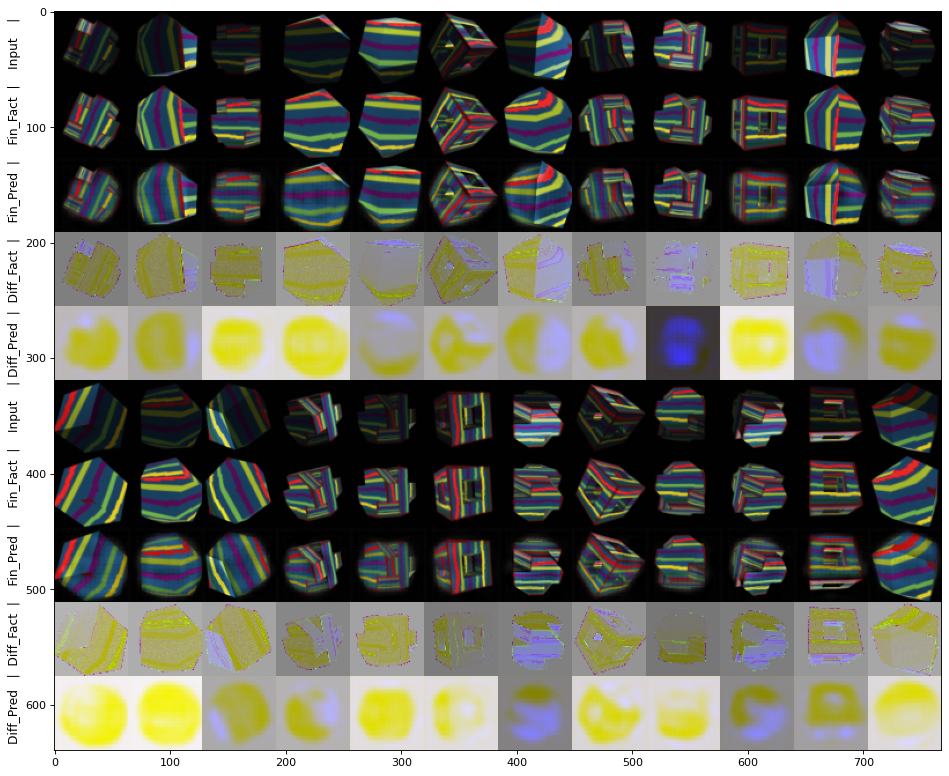

In [30]:
toinset = np.array([i * 100 for i in range(12)])
bigpicture = masstestAlt(toinset, model)
toinset1 = np.array([i * 100 + 50 for i in range(12)])
bigpicture1 = masstestAlt(toinset1, model)
bigpicture = np.concatenate([bigpicture, bigpicture1], axis=0)
bigpicture = bigpicture.astype("float32").clip(0,1)
plt.figure(figsize=(16, 12), dpi=80)
#plt.axis("off")
plt.ylabel("Diff_Pred   |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    | Diff_Pred  |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    |", fontsize=11)
plt.imshow(bigpicture)

In [32]:
model.save("my_hsl_model.keras")

In [23]:
def mass_hsl_rgb(my_list):
    new_list = np.zeros(my_list.shape)
    for i in range(len(my_list)):
        new_list[i] = RGBHSL.image_coverter(np.clip(my_list[i],0,1), RGBHSL.pixel_hsl_to_rgb, normalized_input=True, normalize_output=True)
    return new_list
def mass_norm(my_list):
    new_list = np.zeros(my_list.shape) 
    for i in range(my_list.shape[0]):
        new_list[i] = normalizeNegativeImage(my_list[i], np.zeros((64,64)) + 1)
    return new_list
def masstestAlt(mylist, locmodel):
    inputs = all_photos[mylist]
    
    testanswers = all_differences[mylist]
    testanswers = np.stack([np.zeros((mylist.shape[0], 64,64)), testanswers[:,:,:,0], testanswers[:,:,:,1]], axis = 3)

    answers = np.zeros(inputs.shape)
    for i in range(inputs.shape[0]):
        answers[i] = inputs[i] - testanswers[i] #np.stack([np.zeros((64,64)), testanswers[i,:,:,0], testanswers[i,:,:,1]], axis = 2)

    imgimg = locmodel.predict([inputs])
    imgimg = np.stack([np.zeros((mylist.shape[0],64,64)), imgimg[:,:,:,0], imgimg[:,:,:,1]], axis = 3)

    normalized_truth = mass_norm(testanswers)
    normalized_preds = mass_norm(imgimg)
    #ans = inputs - testanswers
    r0 =  np.concatenate(mass_hsl_rgb(inputs), axis=1)
    r1 =  np.concatenate(mass_hsl_rgb(answers), axis=1)
    r2 =  np.concatenate(mass_hsl_rgb(inputs - imgimg), axis=1)
    r3 =  np.concatenate(normalized_truth, axis=1)
    r4 =  np.concatenate(normalized_preds, axis=1)

    finalimage = np.concatenate([r0, 
                                 r1, 
                                 r2, 
                                 r3, 
                                 r4
                                ], axis=0)
    return finalimage